In [29]:
import os
import pandas as pd

directory_path = 'files/construction_data/BioGRID'

file_extension = '.txt'

dataframes = []
enterez_id_pairs = set()

for file in os.listdir(directory_path):
    if file.endswith(file_extension):
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path, delimiter='\t')
        df = df[(df['Entrez Gene Interactor A'] != '-') & (df['Entrez Gene Interactor B'] != '-')]
        df = df[df['Experimental System Type'] == 'physical']
        df = df[(df['Official Symbol Interactor A'] != '-') & (df['Official Symbol Interactor B'] != '-')]
        print(len(df))      
        dataframes.append(df)

99685
81277
98144


/tmp/ipykernel_10499/87331942.py:14: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t')


In [7]:
print(dataframes[0].columns)

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Pubmed ID',
       'Organism Interactor A', 'Organism Interactor B', 'Throughput', 'Score',
       'Modification', 'Phenotypes', 'Qualifications', 'Tags',
       'Source Database'],
      dtype='object')


In [3]:
official_names_mapping = {}
for df in dataframes:
    for index, row in df.iterrows():
        id_a = str(row['Entrez Gene Interactor A'])
        id_b = str(row['Entrez Gene Interactor B'])
        
        if id_a not in official_names_mapping:
            official_names_mapping[id_a] = row['Official Symbol Interactor A']
            
        if id_b not in official_names_mapping:
            official_names_mapping[id_b] = row['Official Symbol Interactor B']
        
        if id_a != id_b:
            pair = tuple(sorted([id_a, id_b]))
            enterez_id_pairs.add(pair)

In [4]:
len(enterez_id_pairs)

192650

In [5]:
with open("files/network.sif", "w") as file:
    for pair in enterez_id_pairs:
            first = official_names_mapping[pair[0]]
            second = official_names_mapping[pair[1]]
            
            file.write(f"{first}\t-\t{second}\n")

# Bojenje čvorova

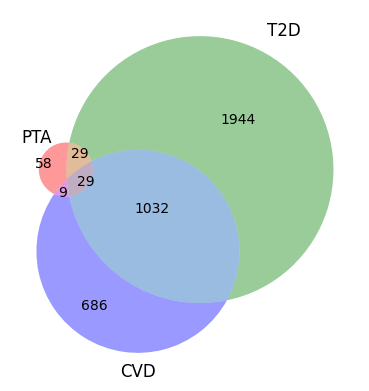

In [7]:
import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

file_path = 'files/disease_genes/'
file_names = ['genes_PTA.xlsx', 'genes_T2D.xlsx', 'genes_CVD.xlsx']

df1 = pd.read_excel(file_path+file_names[0])
df2 = pd.read_excel(file_path+file_names[1])
df3 = pd.read_excel(file_path+file_names[2])

genes_PTA = set(df1['Gene'])
genes_T2D = set(df2['Gene'])
genes_CVD = set(df3['Gene'])

intersection_PTA_T2D_not_CVD = (genes_PTA & genes_T2D) - genes_CVD
intersection_PTA_CVD_not_T2D = (genes_PTA & genes_CVD) - genes_T2D
intersection_T2D_CVD_not_PTA = (genes_T2D & genes_CVD) - genes_PTA
intersection_PTA_CVD_T2D = genes_CVD & genes_PTA & genes_T2D

venn3([genes_PTA, genes_T2D, genes_CVD], ('PTA', 'T2D', 'CVD'))

plt.show()

In [40]:
import py4cytoscape as p4c


p4c.cytoscape_ping()

p4c.session.open_session('output_network.cys')

network_suid = p4c.networks.get_network_suid()

def get_node_color(node):
    if node in intersection_PTA_CVD_T2D:
        return '#A020F0'  
    elif node in intersection_PTA_T2D_not_CVD:
        return '#FFD580'  
    elif node in intersection_T2D_CVD_not_PTA:
        return '#ADD8E6'  
    elif node in intersection_PTA_CVD_not_T2D:
        return '#FF1493'  
    elif node in genes_PTA:
        return '#FF0000'  
    elif node in genes_CVD:
        return '#0000FF'  
    elif node in genes_T2D:
        return '#008000'  
    else:
        return '#CCCCCC'  

node_table = p4c.tables.get_table_columns('node', columns='name')
node_names = node_table['name'].tolist()  

node_colors = [get_node_color(node) for node in node_names]

try:
    p4c.style_bypasses.set_node_property_bypass(node_names, node_colors, visual_property='NODE_FILL_COLOR')
except Exception as e:
    print(f"Greška prilikom primene boja na čvorove: {e}")
    exit()

cys_file_path = 'output_network.cys'
try:
    p4c.session.save_session(cys_file_path)
    print(f"Mreža je učitana, čvorovi su obojeni i sačuvani u {cys_file_path}.")
except Exception as e:
    print(f"Greška prilikom čuvanja sesije: {e}")

You are connected to Cytoscape!
Opening /home/korisnik/Desktop/ip2/proteinclustering/output_network.cys...
This file has been overwritten.
Mreža je učitana, čvorovi su obojeni i sačuvani u output_network.cys.
